<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/8_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = "/content/drive/MyDrive/"
data_name  = "full_rap_df_cleaned_3_classifiers.xlsx"

In [4]:
data = pd.read_excel(file_path + data_name)

# Classifier's Statistics

In [5]:
def plot_statistics(data, col, quest):
    # ספירת המקרים השונים בעמודה
    value_counts = data[col].value_counts()
    print(value_counts)
    # יצירת הגרף
    fig, ax = plt.subplots(figsize=(8, 8))
    wedges, texts, autotexts = ax.pie(
    value_counts,
    labels=quest,
    autopct='%1.1f%%',
    textprops=dict(color="black"),
    startangle=90
)

# התאמת גודל הטקסטים
    plt.setp(autotexts, size=10, weight="bold")
    plt.setp(texts, size=12)
    plt.title(f'Distribution of {col}')

    plt.show()

    # הדפסת הנתונים מתחת לגרף
    print(f"Data distribution for '{col}':")

    total = sum(map(lambda count: count, value_counts))

    print(f"Total of {total} cases where checked.")

* Classifier "other cases" treshold for predction: 0.56. text cut : 400 - 30

* First classiier (requests) treshold : 0.67. text cut: 500 - 30

* Second classifier (appeals) treshold: 0.9. text cut: 550 - 80

---



Others_classifier_treshold_prediction
0    5983
1    1115
Name: count, dtype: int64


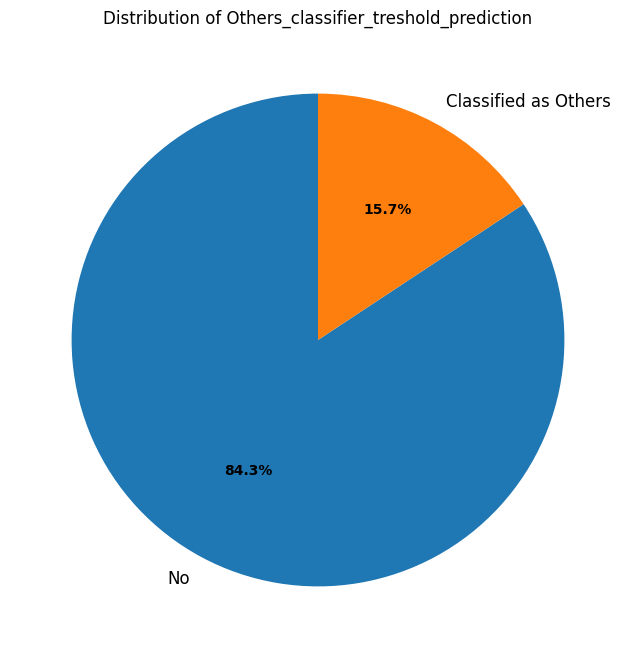

Data distribution for 'Others_classifier_treshold_prediction':
Total of 7098 cases where checked.


In [6]:
plot_statistics(data,'Others_classifier_treshold_prediction',['No','Classified as Others'])

first_classifier_treshold_prediction
0.0    5690
1.0     293
Name: count, dtype: int64


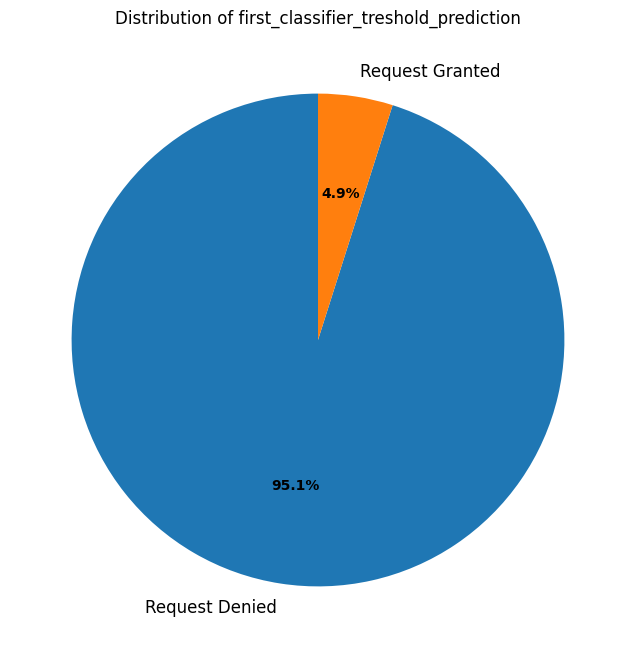

Data distribution for 'first_classifier_treshold_prediction':
Total of 5983 cases where checked.


In [7]:
plot_statistics(data,'first_classifier_treshold_prediction',['Request Denied','Request Granted'])

second_classifier_treshold_prediction
1.0    156
0.0    137
Name: count, dtype: int64


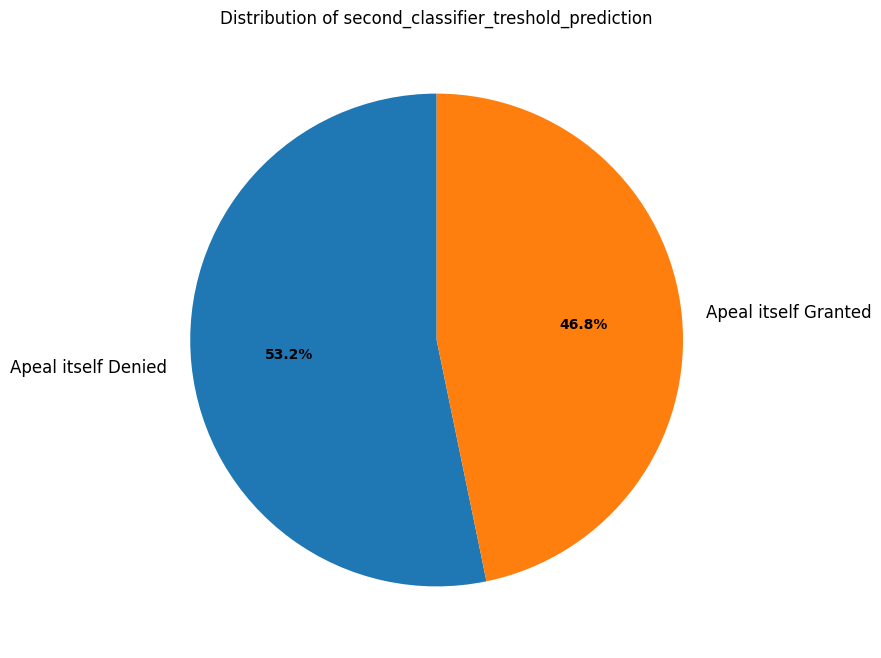

Data distribution for 'second_classifier_treshold_prediction':
Total of 293 cases where checked.


In [8]:
plot_statistics(data,'second_classifier_treshold_prediction',['Apeal itself Denied','Apeal itself Granted'])

# Add public and private sides

In [9]:
sides_path = "sides_values with lables.xlsx"
sides_df = pd.read_excel(file_path+sides_path)

In [10]:
sides_df["Public Sides"].unique()[5]

' באמצעות השירות המשפטי של עיריית תל אביב'

In [11]:
sides_df["Private Sides"].unique()[5]

'   ניקולאי טיטוב  ויקטור שניידרמן  אלכסיי וולוביק'

In [12]:
def debug_message(message, value=None):
    if value is not None:
        print(f"{message}: {value}")
    else:
        print(message)

def safe_str(value):
    """
    Converts a value to a safe string, handling non-string types gracefully.
    """
    try:
        if pd.isna(value) or value == "" or value == []:
            return ""
        if isinstance(value, list):
            return " ".join([str(v) for v in value if isinstance(v, str)]).strip()
        return str(value).strip()
    except Exception as e:
        debug_message("Error converting value to string", value)
        return ""

# פונקציה לניקוי טקסט
# פונקציה לניקוי טקסט
def clean_text(text):
    """
    Cleans the text by removing unwanted characters and fixing formatting issues.
    """
    # Remove leading and trailing whitespace
    text = text.strip()

    # Fix \n or n between Hebrew words
    text = re.sub(r'(?<=[\u0590-\u05FF])\s*[n\\n]+\s*(?=[\u0590-\u05FF])', ' ', text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[\\/]', '', text)

    return text

def publc_side(value, sides_df):
    """
    Determines if the value belongs to a public entity based on predefined lists and patterns.
    """
    try:
        value = safe_str(value)
        value_cleaned = clean_text(value)

        # בדיקת מילים קבועות בתור "ציבורי"
        keywords = sides_df["Public Sides"].dropna().unique().tolist()
        public_terms = [
        "רשות מקרקעי ישראל", "מדינת ", "מועצה ", "שירות ה", "היחידה הארצי", "מדינתישראל", "לאכיפת ", "הרשות ל", "חוף ",
        "המשרד ל", 'יועמ"ש', "המשפטי לממשלה", "מנהל מקרקעי", "פרקליטות", "שירות בתי הסוהר", 'שב"ס', 'מע"מ', "מכס ", 'קמ"ט',
        "ועדת תכנון", "מרכז השלטון", "משטרה", "הסנגוריה הציבורית", "מינהל מקרקעי", "עירית ", "רשויות", "איגוד ערים",
        "עיריית ", "מדינת ישראל", "משרד ה", "מקרקעי ישראל", "שר ה", "שרת ה", "מועצת ", 'רנ"ג', "סרן", "מחוז ","מחש",
        "מ דינת ישראל", "שרות בתי הסוהר", 'סג"ם', "(במיל)", "(מיל)", "עריית ", "המחלקה לחקירת שוטרים", "יושבי ראש",'מח"ש'
        "רשות ה", "אלוף ", 'יו"ר', "יושב ראש", "ראש עיריית", "ועדה", "צבא", "מפקד", "פיקוד", "משטרת", "משטרה",'רנ"ג',"המחלקה לחקירות שוטרים"
    ]
        # אם אחד מהמונחים מופיע, צד ציבורי
        if any(term in value_cleaned for term in public_terms + keywords):
            return 1

        # במידה ואין התאמה, נבדוק לפי אורכים ודפוסים כלליים
        if len(value_cleaned) > 5:
            return 0

        return None
    except Exception as e:
        return None


def assign_state_side_b(value, sides_df):
    """
    Maps the side to public ('ב'), private ('א'), or undefined ('לא מוגדר').
    """
    try:
        value = safe_str(value)
        result = publc_side(value, sides_df)

        if result == 1:
            return "ב"

        elif result == 0:
            return None
        else:
            return "לא מוגדר"
    except Exception as e:
        debug_message("Error assigning state side for value", value)
        return "לא מוגדר"

def assign_state_side_a(value, sides_df):
    """
    Maps the side to public ('ב'), private ('א'), or undefined ('לא מוגדר').
    """
    try:
        value = safe_str(value)
        result = publc_side(value, sides_df)

        if result == 1:
            return "א"
        elif result == 0:
            return None
        else:
            return "לא מוגדר"
    except Exception as e:
        debug_message("Error assigning state side for value", value)
        return "לא מוגדר"

In [13]:
check_nulls_b = data[data["צד ב'"].isna()]
check_nulls_b["צד א'"].unique()

array(["[['יואב פרנקל', 'מילי פרנקל']]", "[['שופאני כרם']]",
       "[['אלי חי']]", "[['עופר בראז']]", "[['פלוני']]",
       "[['אבו קרינאת עבדאללה ת.ז. 029856184 ']]", nan,
       "[['צבי שטיין ']]", "[['דניאל בן עזרא עמרם']]", "[['עזרא לקס']]",
       "[['חיים חוטה']]", "[['ארקדי אלזרוב']]", "[['אליעזר משיאשוילי']]",
       "[['יעקב שאיו']]", "[['מוחמד קעדאן']]", "[['נאסר רומל']]",
       "[['יצחק זינגר']]", "[['טלאל מלאחי']]", "[['פריד שלבי']]",
       "[['אליעזר לביא']]", "[['יגאל מדר']]", "[['איברהים חאג יחיא']]",
       "[['בועז פרחי']]", "[['אוריאל דודסון ']]", "[['אליהו מחפוד ']]",
       "[['איתמר נמדר ']]", "[['טוליב רחימוב ']]", "[['מוחמד משהראוי']]",
       "[['אברהם שריקי']]", "[['ציון זלה']]", "[['מאיר טוללה ']]",
       "[['יוסף סוריאס ']]", "[['שי שווגר ']]", "[['רן אברי ']]",
       "[['ליאור אבוקסיס ']]", "[['בועז אברהם ']]", "[['רחמים נחום ']]",
       "[['רפאל ואקין']]", "[['דרור כהן']]", "[['גאלב חרחש']]",
       "[['משה חדש']]", "[['אמיר אורלי']]", "[['אשר יגודייב

In [14]:
def unknown_terms(value):
    empty_values = ["לא מוגדר","", "None", "NaN", "null", "NULL", "n/a", "N/A", "#N/A", "NA"]
    return pd.isna(value) or value in empty_values or (isinstance(value, str) and value.strip() == '')

data["צד המדינה"] = data["צד א'"].apply(lambda x: assign_state_side_a(x, sides_df))
data["צד המדינה"] = data.apply(
    lambda row: assign_state_side_b(row["צד ב'"], sides_df) if unknown_terms(row["צד המדינה"]) else row["צד המדינה"],
    axis=1
)

In [36]:

unknown_values = data[data["צד המדינה"] == "לא מוגדר"]

unknown_values.head()

,index,מספר תיק,מספר החלטות בתיק,שם הליך,שנת פתיחת ההליך,מספר הליך,סוג הליך,פירוט סוג הליך,תיק חסוי,תאריך אירוע אחרון,...,Others_classifier_treshold_prediction,גוף המסמך חתוך - embeddings,first_classifier_predicted_probability,first_classifier_original_prediction,first_classifier_treshold_prediction,גוף המסמך חתוך למסווג השני - embeddings,second_classifier_predicted_probability,second_classifier_original_prediction,second_classifier_treshold_prediction,צד המדינה
519,9490,9265/09,2,"רע""פ 9265/09 מילי פרנקל נ. מדינת ישראל",2009,"רע""פ 9265/09","רע""פ",רשות ערעור פלילי,0.0,2009-11-23,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,לא מוגדר
843,14813,5127/07,5,"רע""פ 5127/07 שופאני כרמ נ. מדינת ישראל",2007,"רע""פ 5127/07","רע""פ",רשות ערעור פלילי,0.0,2007-07-19,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,לא מוגדר
998,17620,3466/16,5,"רע""פ 3466/16",2016,"רע""פ 3466/16","רע""פ",רשות ערעור פלילי,0.0,2017-02-21,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,לא מוגדר
1506,2040,230/14,1,"רע""פ 230/14 עופר ברא''ז נ. הועדה המקומית לתכנו...",2014,"רע""פ 230/14","רע""פ",רשות ערעור פלילי,0.0,2014-01-16,...,0,[ 4.19343919e-01 -6.21535741e-02 -4.13136780e-...,0.004019,0.0,0.0,NaN,NaN,NaN,NaN,לא מוגדר
1661,2269,5449/14,2,"רע""פ 5449/14",2014,"רע""פ 5449/14","רע""פ",רשות ערעור פלילי,1.0,1900-01-01,...,0,[ 3.05338472e-01 -1.32924259e-01 -3.86319458e-...,0.020070,0.0,0.0,NaN,NaN,NaN,NaN,לא מוגדר


In [33]:
unknown_values["צד ב'"].unique()

array([nan], dtype=object)

In [17]:
unknown_values["צד א'"].unique()

array(["[['יואב פרנקל', 'מילי פרנקל']]", "[['שופאני כרם']]",
       "[['אלי חי']]", "[['עופר בראז']]", "[['פלוני']]",
       "[['אבו קרינאת עבדאללה ת.ז. 029856184 ']]", nan,
       "[['צבי שטיין ']]", "[['דניאל בן עזרא עמרם']]", "[['עזרא לקס']]",
       "[['חיים חוטה']]", "[['ארקדי אלזרוב']]", "[['אליעזר משיאשוילי']]",
       "[['יעקב שאיו']]", "[['מוחמד קעדאן']]", "[['נאסר רומל']]",
       "[['יצחק זינגר']]", "[['טלאל מלאחי']]", "[['פריד שלבי']]",
       "[['אליעזר לביא']]", "[['יגאל מדר']]", "[['איברהים חאג יחיא']]",
       "[['בועז פרחי']]", "[['אוריאל דודסון ']]", "[['אליהו מחפוד ']]",
       "[['איתמר נמדר ']]", "[['טוליב רחימוב ']]", "[['מוחמד משהראוי']]",
       "[['אברהם שריקי']]", "[['ציון זלה']]", "[['מאיר טוללה ']]",
       "[['יוסף סוריאס ']]", "[['שי שווגר ']]", "[['רן אברי ']]",
       "[['ליאור אבוקסיס ']]", "[['בועז אברהם ']]", "[['רחמים נחום ']]",
       "[['רפאל ואקין']]", "[['דרור כהן']]", "[['גאלב חרחש']]",
       "[['משה חדש']]", "[['אמיר אורלי']]", "[['אשר יגודייב

צד המדינה
ב           6904
א             72
לא מוגדר      56
Name: count, dtype: int64


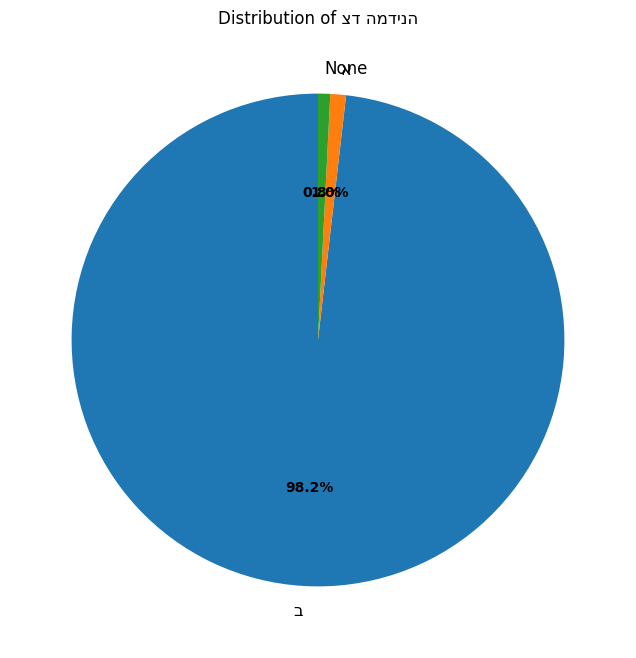

Data distribution for 'צד המדינה':
Total of 7032 cases where checked.


In [34]:
plot_statistics(data,'צד המדינה',['ב',"א",'None'])

In [19]:
data.to_excel(file_path + "בית המשפט - קבצים סופיים/full_rap_df_cleaned_3_classifiers_with_state's_side.xlsx", index=False)

# הוספת צד מדינה לכל הדאטה

In [20]:
all_data = pd.read_excel(file_path+
    "full_rap_df_cleaned.xlsx",
    engine='openpyxl'
)

In [21]:
all_data.shape

(7658, 152)

In [22]:
def unknown_terms(value):
    empty_values = ["לא מוגדר","", "None", "NaN", "null", "NULL", "n/a", "N/A", "#N/A", "NA"]
    return pd.isna(value) or value in empty_values or (isinstance(value, str) and value.strip() == '')

all_data["צד המדינה"] = all_data["צד א'"].apply(lambda x: assign_state_side_a(x, sides_df))
all_data["צד המדינה"] = all_data.apply(
    lambda row: assign_state_side_b(row["צד ב'"], sides_df) if unknown_terms(row["צד המדינה"]) else row["צד המדינה"],
    axis=1
)

In [23]:
all_data.to_excel("/content/drive/MyDrive/בית המשפט - קבצים סופיים/full_rap_df_cleaned_with_state_side.xlsx")

In [24]:
all_data[all_data["צד המדינה"]=="לא מוגדר"]["צד ב'"].head()

,צד ב'
81,NaN
166,NaN
182,NaN
325,NaN
438,NaN


# סטטיסטיקה עבור צד המדינה לכל תיקי הרע"פ

צד המדינה
ב           7441
א             91
לא מוגדר      52
Name: count, dtype: int64


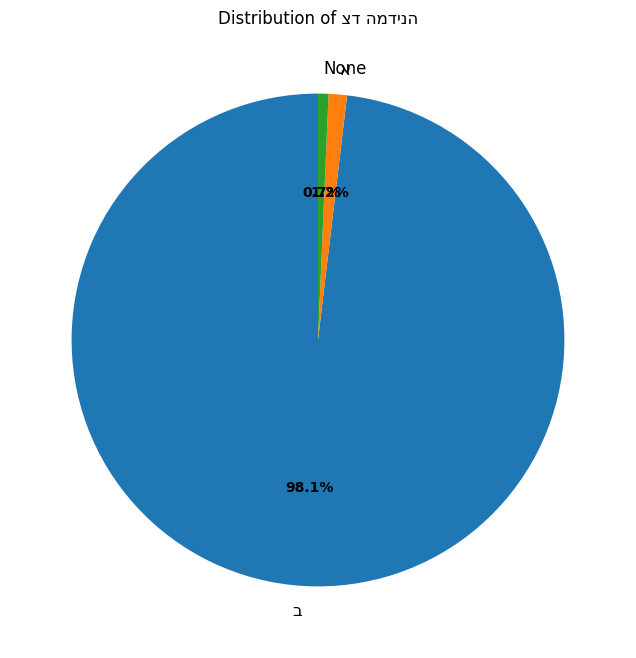

Data distribution for 'צד המדינה':
Total of 7584 cases where checked.


In [35]:
plot_statistics(all_data,'צד המדינה',['ב',"א",'None'])

In [26]:
path = "/content/drive/MyDrive/בית המשפט - קבצים סופיים"

unknown_values = all_data[all_data["צד המדינה"] == "לא מוגדר"]

unknown_values.to_excel(path + "/תיקים בהם צד המדינה לא הוגדר.xlsx", index=False)

In [27]:
unknown_values["צד א'"].unique()[1:5]

array(["[['ברק ימיני']]", "[['מחמוד מחאגנה']]", "[['משה מזרחי']]",
       "[['כראדי שמעון']]"], dtype=object)

In [28]:
only_known_sides = all_data[all_data["צד המדינה"] != "לא מוגדר"]

In [29]:
private_side_list = np.concatenate((
    only_known_sides[only_known_sides["צד המדינה"] == "א"]["צד ב'"].unique(),
    only_known_sides[only_known_sides["צד המדינה"] == "ב"]["צד א'"].unique()
))

In [30]:
public_side_list = np.concatenate((
    only_known_sides[only_known_sides["צד המדינה"]=="ב"]["צד ב'"].unique(),
    only_known_sides[only_known_sides["צד המדינה"]=="א"]["צד א'"].unique()
))

In [31]:
public_side_list = list(set(public_side_list))
private_side_list = list(set(private_side_list))

In [32]:
max_length = max(len(public_side_list), len(private_side_list))
public_side_list.extend([None] * (max_length - len(public_side_list)))
private_side_list.extend([None] * (max_length - len(private_side_list)))

sides_Public_Private = pd.DataFrame({"Public Side": public_side_list, "Private Side": private_side_list})

path = "/content/drive/MyDrive/בית המשפט - קבצים סופיים"
output_path = path + "/sides_Public_Private.xlsx"
sides_Public_Private.to_excel(output_path, index=False)